In [103]:
RUN_MINI_BATCH_COMPARISON=False #Turn off for faster run
SAVE_PLOTS=False

#wordcloud resolution:
WIDTH=800
HEIGHT=600

In [104]:
#Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

#Import required packages
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from IPython.display import display, clear_output

#Add the repo root (one level up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
#Install necessary resources from nltk
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 1. Download data

In [106]:
import kagglehub

#Download latest version of dataset
print("Load or download dataset...")
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset") #path to downloaded dataset
#   (if already downloaded, will not download again)

fake_path=os.path.join(path, "Fake.csv")    #path to dataset with true news
true_path=os.path.join(path, "True.csv")    #path to dataset with fake news

#Read into dataframes
print("Loading fake.csv ...")
fake_df=pd.read_csv(fake_path)
print("Loading true.csv ...")
true_df=pd.read_csv(true_path)

#Label data (1=true, 0=fakenews)
true_df['label']=1
fake_df['label']=0

#Join dataframes
df=pd.concat([true_df, fake_df])
print("Done")


Load or download dataset...
Loading fake.csv ...
Loading true.csv ...
Done


## 2. Preprocess data

In [107]:
from courselib.utils.splits import train_test_split

training_data_fraction=.8

#Split
df_, train_df, test_df=train_test_split(df, training_data_fraction=training_data_fraction, class_column_name='label', return_numpy=False)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from courselib.utils.normalization import standardize_sparse_matrix

column='title' #column of df to vectorize


#Vectorize
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform((train_df[column]))
X_test=vectorizer.transform((test_df[column]))
X=sp.vstack([X_train, X_test])

Y_train=train_df['label'].to_numpy()
Y_test=test_df['label'].to_numpy()

#-1, 1 labels for SVM
Y_train_neg=Y_train.copy()
Y_train_neg[Y_train_neg==0]=-1
Y_test_neg=Y_test.copy()
Y_test_neg[Y_test_neg==0]=-1

#Apply additional z-score normalization (works better for svm)
X, offset=standardize_sparse_matrix(X)
X_train, X_test=X[:len(train_df)], X[len(train_df):]

In [109]:
num_features=X_train.shape[1] #number of extracted features from train_df[column]
num_features

19583

## 3. Comparison of different models

In [110]:
from courselib.models.glm import LogisticRegression
from courselib.models.svm import LinearSVM, BinaryKernelSVM
from courselib.optimizers import GDOptimizer

lr_LR=10 #learning rate LogisticRegression model
lr_SVM=0.001 #learning rate LinearSVM model

#Initialize optimizers
optimizer_LR=GDOptimizer(lr_LR) #optimizer LogisticRegression
optimizer_SVM=GDOptimizer(lr_SVM) #optimizer LinearSVM



In [111]:
import time
from courselib.utils.metrics import binary_accuracy, precision, recall, f1_score

num_epochs=100 #number of epochs
bs=len(train_df) #batch size

results=[]


#Initialize models
w=np.zeros(num_features) #initial weight
b=0 #initial bias
model_LR=LogisticRegression(w,b, optimizer=optimizer_LR, offset=offset)
model_SVM=LinearSVM(w,b, optimizer=optimizer_SVM, offset=offset)

#Training:
metrics_dict_LR={'train accuracy': lambda y_pred,y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[0,1]),
                'test accuracy': lambda y_pred,y_true: binary_accuracy(model_LR.decision_function(X_test),Y_test,class_labels=[0,1])}
metrics_dict_SVM={'train accuracy': lambda y_pred,y_true: binary_accuracy(y_pred=y_pred, y_true=y_true, class_labels=[-1,1]),
                'test accuracy': lambda y_pred,y_true: binary_accuracy(model_SVM.decision_function(X_test),Y_test_neg,class_labels=[-1,1])}

start_LR=time.time()
metrics_history_LR=model_LR.fit(X_train, Y_train, num_epochs=num_epochs, batch_size=bs, compute_metrics=True, metrics_dict=metrics_dict_LR)
end_LR=time.time()

start_SVM=time.time()
metrics_history_SVM=model_SVM.fit(X_train, Y_train_neg, num_epochs=num_epochs, batch_size=bs, compute_metrics=True, metrics_dict=metrics_dict_SVM)
end_SVM=time.time()




results.append({'model':'LogisticRegression', 'batch size': 'full' if bs==len(train_df) else bs,
         'train accuracy [%]':round(metrics_history_LR['train accuracy'][-1],2),
         'test accuracy [%]':round(metrics_history_LR['test accuracy'][-1],2), 'training time [s]': round(end_LR-start_LR,2), 
         'precision test': round(precision(model_LR(X_test), Y_test),2), 
         'recall test': round(recall(model_LR(X_test), Y_test),2), 
         'f1-score test': round(f1_score(model_LR(X_test), Y_test),2)
         })
results.append({'model':'LinearSVM', 'batch size': 'full' if bs==len(train_df) else bs,
              'train accuracy [%]':round(metrics_history_SVM['train accuracy'][-1],2),
              'test accuracy [%]':round(metrics_history_SVM['test accuracy'][-1],2), 'training time [s]': round(end_SVM-start_SVM,2),
              'precision test': round(precision(model_SVM(X_test), Y_test_neg),2), 
              'recall test': round(recall(model_SVM(X_test), Y_test_neg),2), 
              'f1-score test': round(f1_score(model_SVM(X_test), Y_test_neg),2)
         })
results_df=pd.DataFrame(results)
results_df

,model,batch size,train accuracy [%],test accuracy [%],training time [s],precision test,recall test,f1-score test
0,LogisticRegression,full,100.0,95.60,1.88,0.95,0.96,0.95
1,LinearSVM,full,99.4,95.35,2.58,0.94,0.96,0.95


Text(0.5, 1.0, 'Confusion matrix LinearSVM')

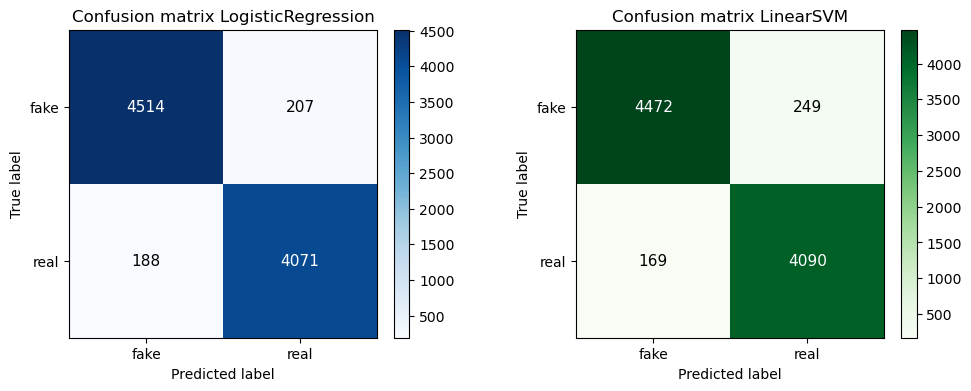

In [154]:
from courselib.utils.metrics import binary_confusion_matrix, plot_confusion_matrix
fig,ax=plt.subplots(1,2, figsize=(12,4))
plot_confusion_matrix(binary_confusion_matrix(y_true=Y_test, y_pred=model_LR(X_test), plot=False),ax=ax[0], show_plt=False, class_names=['fake', 'real'], rotation=0, ha='center')
plot_confusion_matrix(binary_confusion_matrix(y_true=Y_test_neg, y_pred=model_SVM(X_test), plot=False, labels=[-1,1]),cmap='Greens',ax=ax[1], show_plt=False,class_names=['fake', 'real'], rotation=0, ha='center')
ax[0].set_title('Confusion matrix LogisticRegression')
ax[1].set_title('Confusion matrix LinearSVM')

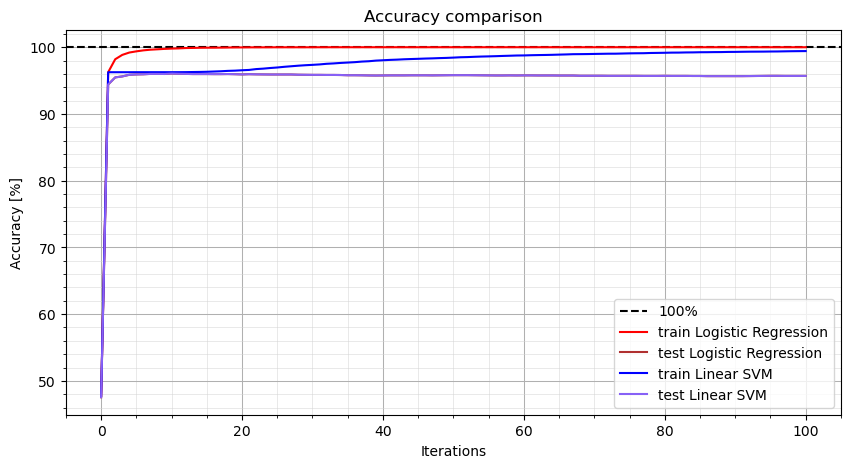

In [ ]:
#Plot
fig,ax=plt.subplots(figsize=(10,5))
ax.axhline(y=100, color='black', linestyle='--', label='100%')
ax.plot(range(len(metrics_history_LR['train accuracy'])),metrics_history_LR['train accuracy'], label="train Logistic Regression", color='red')
ax.plot(range(len(metrics_history_LR['test accuracy'])),metrics_hisatory_LR['test accuracy'], label="test Logistic Regression", color="#B03030")
ax.plot(range(len(metrics_history_SVM['train accuracy'])),metrics_history_SVM['train accuracy'], label="train Linear SVM", color='blue')
ax.plot(range(len(metrics_history_SVM['test accuracy'])),metrics_history_LR['test accuracy'], label="test Linear SVM", color="#8761F6")
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy [%]')
# Turn on minor ticks automatically
ax.minorticks_on()

# Major grid: solid, normal
ax.grid(which='major', linestyle='-', linewidth=0.75)

# Minor grid: dashed, light
ax.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
ax.set_title('Accuracy comparison')
plt.show()


### 3.1. Comparison with mini batch

In [90]:
if RUN_MINI_BATCH_COMPARISON:    
       bs=100 #batch size to compare
       lr_LR2=0.01 #learning rate LogisticRegression model (this learning rate performed better for mini batch)
       lr_SVM2=0.001 #learning rate LinearSVM model

       #Initialize optimizers
       optimizer_LR2=GDOptimizer(lr_LR2) #optimizer LogisticRegression
       optimizer_SVM2=GDOptimizer(lr_SVM2) #optimizer LinearSVM


       model_LR2=LogisticRegression(w,b, optimizer=optimizer_LR2, offset=offset)
       model_SVM2=LinearSVM(w,b, optimizer=optimizer_SVM2, offset=offset)


       start_LR2=time.time()
       model_LR2.fit(X_train, Y_train, num_epochs=num_epochs, batch_size=bs)
       end_LR2=time.time()

       start_SVM2=time.time()
       model_SVM2.fit(X_train, Y_train_neg, num_epochs=num_epochs, batch_size=bs)
       end_SVM2=time.time()


       results.append({'model':'LogisticRegression', 'batch size': 'full' if bs==len(train_df) else bs,
              'train accuracy [%]':round(binary_accuracy(model_LR2(X_train), Y_train, class_labels=[0,1]),2),
              'test accuracy [%]':round(binary_accuracy(model_LR2(X_test), Y_test, class_labels=[0,1]),2), 
              'training time [s]': round(end_LR2-start_LR2,2)
              })
       results.append({'model':'LinearSVM2', 'batch size': 'full' if bs==len(train_df) else bs,
              'train accuracy [%]':round(binary_accuracy(model_SVM2(X_train), Y_train_neg, class_labels=[-1,1]),2),
              'test accuracy [%]':round(binary_accuracy(model_SVM2(X_test), Y_test_neg, class_labels=[-1,1]),2), 
              'training time [s]': round(end_SVM2-start_SVM2,2)
              })
       results_df=pd.DataFrame(results)
       display(results_df)

## 4. Vectorization and Tokenization Comparison

### 4.1 Performance with different numbers of features

In [91]:
from courselib.utils.preprocessing import multi_column_vectorizer

num_features=[1,10, 100, 500]+list(range(1000, 20000,1000))+[None] #None=all features
columns=['title']

lr=10 #learning rate
epochs=100
bs=len(train_df)

optimizer=GDOptimizer(lr)

In [92]:
train_accuracies=[]
test_accuracies=[]

for n in num_features:
     #Vectorize
    vectorizer=multi_column_vectorizer(col_names=columns,max_features_per_column=n)
    X_train=vectorizer.fit_transform(train_df)
    X_test=vectorizer.transform(test_df)
    X=sp.vstack([X_train, X_test])

    #Apply additional z-score normalization (works better for svm)
    X, offset=standardize_sparse_matrix(X)
    X_train, X_test=X[:len(train_df)], X[len(train_df):]

    #Initialize model
    w=np.zeros(X_train.shape[1])
    b=0
    model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

    #Train
    model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)

    train_accuracies.append(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]))
    test_accuracies.append(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]))

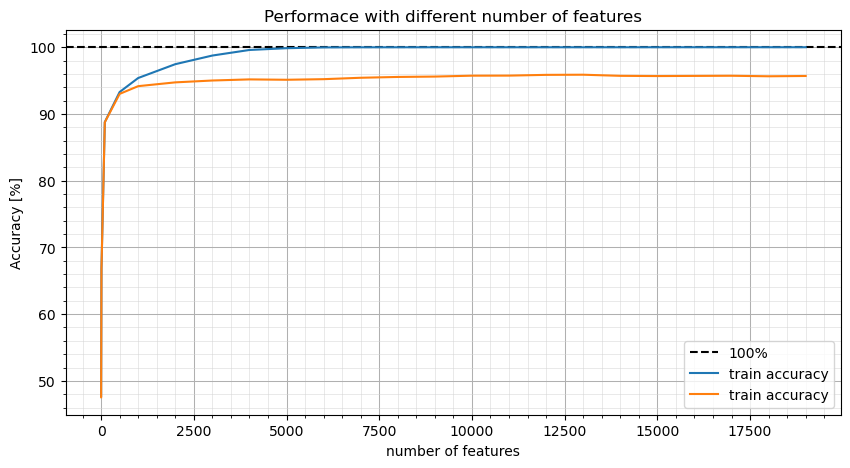

In [93]:
#Plot
fig,ax=plt.subplots(figsize=(10,5))
ax.axhline(y=100, color='black', linestyle='--', label='100%')
ax.plot(num_features,train_accuracies, label="train accuracy")
ax.plot(num_features,test_accuracies, label="train accuracy")
ax.legend()
ax.set_xlabel('number of features')
ax.set_ylabel('Accuracy [%]')
# Turn on minor ticks automatically
ax.minorticks_on()

# Major grid: solid, normal
ax.grid(which='major', linestyle='-', linewidth=0.75)

# Minor grid: dashed, light
ax.grid(which='minor', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
ax.set_title('Performace with different number of features')
plt.show()


### 4.2 Influence of different vectorizations

In [94]:
from courselib.utils.preprocessing import basic_word_tokenizer, stemming_tokenizer, lemmatization_tokenizer

tokenizers={'default': None, 'basic':basic_word_tokenizer, 'stemming': stemming_tokenizer, 'lemmatization':lemmatization_tokenizer }
vectorization_types=['tf-idf', 'bag-of-words']
stop_words=[None, 'english']

In [95]:
results_vectorization=[]

for vt in vectorization_types:
    for sw in stop_words:
        for tk_name, tk in tokenizers.items():
            #Vectorize
            vect_start=time.time()
            vectorizer=multi_column_vectorizer(col_names=columns,vectorization=vt, stop_words=sw, tokenizer=tk)
            X_train=vectorizer.fit_transform(train_df)
            X_test=vectorizer.transform(test_df)
            X=sp.vstack([X_train, X_test])

            #Apply additional z-score normalization (works better for svm)
            X, offset=standardize_sparse_matrix(X)
            X_train, X_test=X[:len(train_df)], X[len(train_df):]
            vect_end=time.time()

            #Initialize model
            w=np.zeros(X_train.shape[1])
            b=0
            model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

            #Train
            model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)

            train_accuracy=round(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]),2)
            test_accuracy=round(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]),2)
            num_features=X_train.shape[1]

            results_vectorization.append({
                'vectorization type': vt, 'stop words': sw, 'tokenizer':tk_name,'number of features': num_features,
                'train accuracy [%]':train_accuracy, 'test accuracy [%]': test_accuracy,
                'precision test': round(precision(model(X_test), Y_test),2), 
                'recall test': round(recall(model(X_test), Y_test),2), 
                'f1-score test': round(f1_score(model(X_test), Y_test),2),
                'vectorization time [s]': round(vect_end-vect_start,2)
            })
            results_vectorization_df=pd.DataFrame(results_vectorization)
            clear_output(wait=True)
            display(results_vectorization_df)

,vectorization type,stop words,tokenizer,number of features,train accuracy [%],test accuracy [%],precision test,recall test,f1-score test,vectorization time [s]
0,tf-idf,None,default,19562,100.00,95.70,0.95,0.96,0.95,1.16
1,tf-idf,None,basic,24960,100.00,96.96,0.97,0.97,0.97,8.21
2,tf-idf,None,stemming,17404,100.00,96.69,0.96,0.97,0.97,18.03
3,tf-idf,None,lemmatization,20908,100.00,96.88,0.96,0.97,0.97,65.70
4,tf-idf,english,default,19290,100.00,94.51,0.94,0.94,0.94,1.19
5,tf-idf,english,basic,24690,100.00,96.34,0.96,0.96,0.96,9.50
6,tf-idf,english,stemming,17264,100.00,95.84,0.95,0.96,0.96,18.67
7,tf-idf,english,lemmatization,20864,100.00,96.09,0.96,0.96,0.96,54.19
8,bag-of-words,None,default,19562,100.00,95.79,0.96,0.96,0.96,1.20
9,bag-of-words,None,basic,24960,100.00,97.07,0.97,0.97,0.97,8.84


### 4.3 Influence of n-grams

In [97]:
ngram_ranges=[(1,1), (1,2), (1,3),(2,2), (3,3)]

In [98]:
results_ngram=[]
vectorizers={}
weights={}

for ngram in ngram_ranges:
    #Vectorize
    vect_start=time.time()
    vectorizer=multi_column_vectorizer(col_names=columns,ngram_range=ngram)
    X_train=vectorizer.fit_transform(train_df)
    X_test=vectorizer.transform(test_df)
    X=sp.vstack([X_train, X_test])

    #Apply additional z-score normalization (works better for svm)
    X, offset=standardize_sparse_matrix(X)
    X_train, X_test=X[:len(train_df)], X[len(train_df):]
    vect_end=time.time()
    vectorizers.update({ngram: vectorizer})

    #Initialize model
    w=np.zeros(X_train.shape[1])
    b=0
    model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

    #Train
    model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)

    train_accuracy=round(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]),2)
    test_accuracy=round(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]),2)
    num_features=X_train.shape[1]
    weights.update({ngram:model.w})

    results_ngram.append({
        'ngram range':ngram,'number of features': num_features,
            'train accuracy [%]':train_accuracy, 'test accuracy [%]': test_accuracy,
            'vectorization time [s]': round(vect_end-vect_start,2)
    })
    results_ngram_df=pd.DataFrame(results_ngram)
    clear_output(wait=True)
    display(results_ngram_df)

,ngram range,number of features,train accuracy [%],test accuracy [%],vectorization time [s]
0,"(1, 1)",19562,100.0,95.70,1.20
1,"(1, 2)",211876,100.0,95.65,3.83
2,"(1, 3)",495774,100.0,94.04,6.79
3,"(2, 2)",192314,100.0,92.13,2.38
4,"(3, 3)",283898,100.0,71.82,2.47


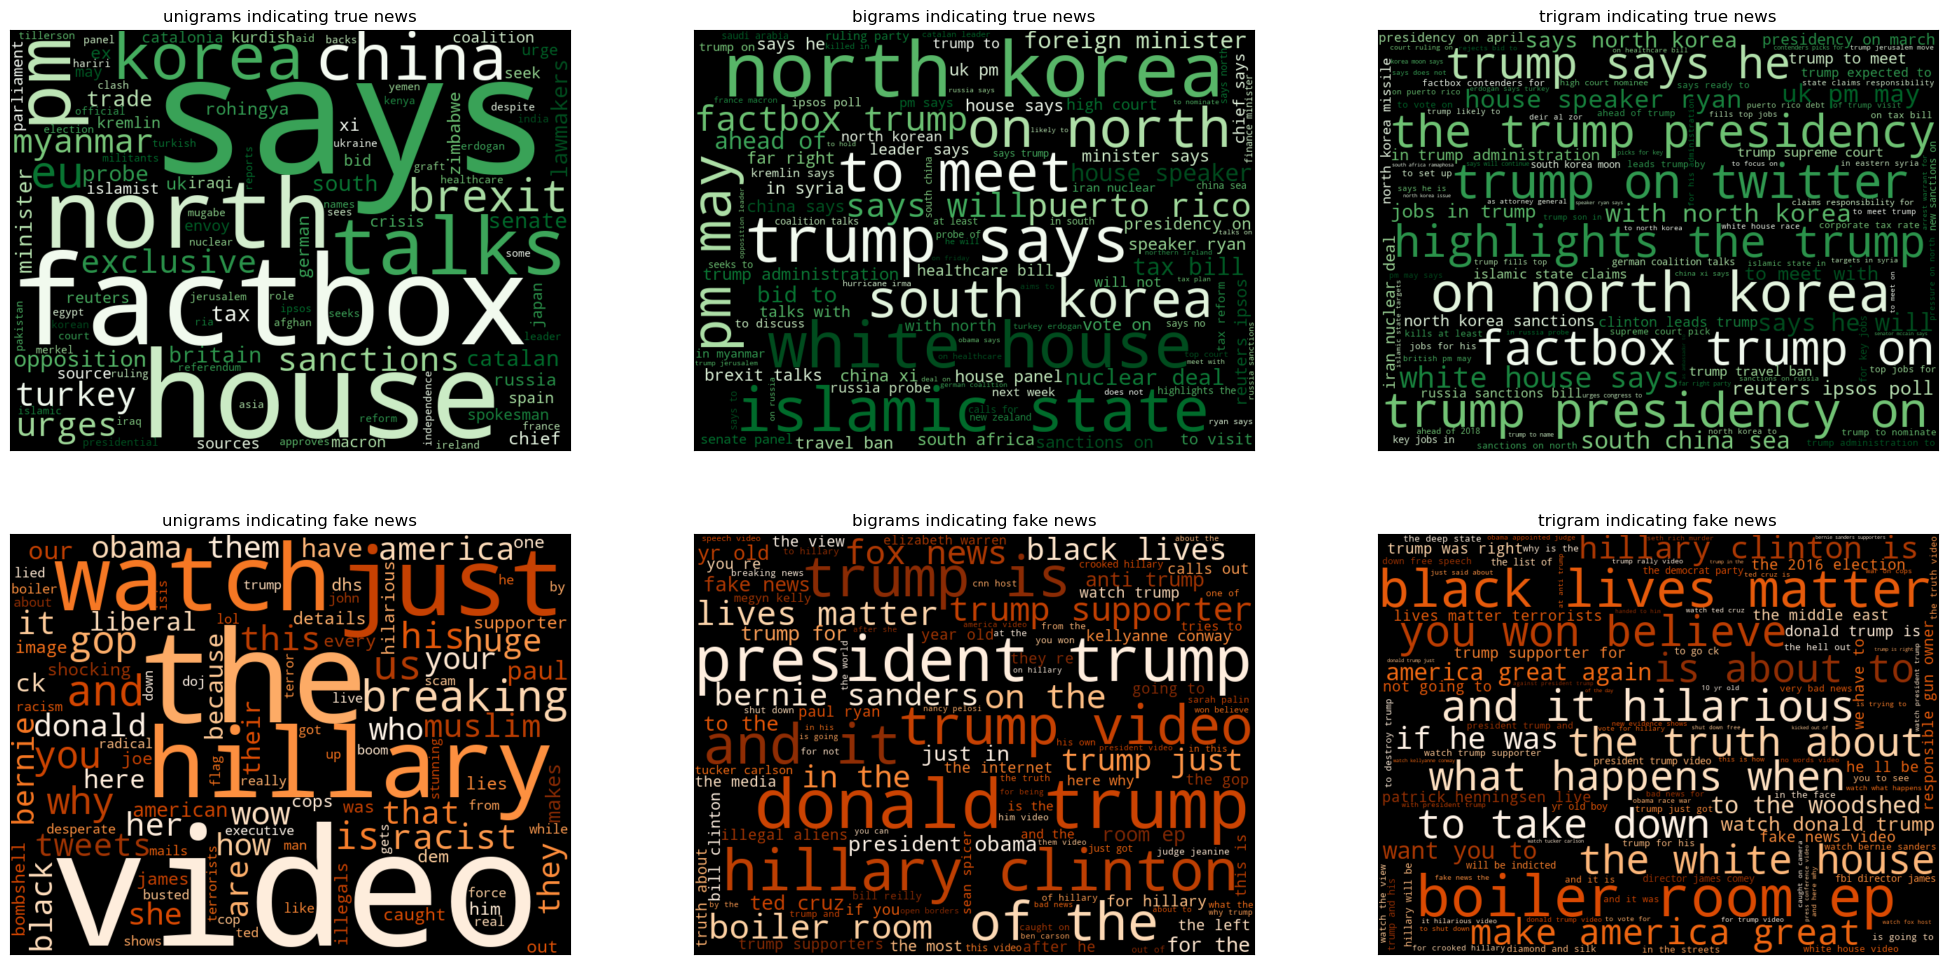

In [99]:
from wordcloud import WordCloud

fig, ax=plt.subplots(2,3, figsize=(25,12))
for i,ngram in enumerate([(1,1), (2,2), (3,3)]):
    ngram_name=['unigrams', 'bigrams', 'trigram'][i]
    weights_pos=weights[ngram]
    weights_neg=-weights_pos
    features=vectorizers[ngram].get_feature_names_out()[columns[0]]
    word_importance_true={word: weight for (word,weight) in zip(features, weights_pos)}
    word_importance_fake={word: weight for (word,weight) in zip(features, weights_neg)}
    wordcloud_true=WordCloud(max_words=100, width=WIDTH, height=HEIGHT, colormap='Greens').generate_from_frequencies(word_importance_true)
    wordcloud_fake=WordCloud(max_words=100, width=WIDTH, height=HEIGHT, colormap='Oranges').generate_from_frequencies(word_importance_fake)

    ax[0,i].imshow(wordcloud_true, interpolation='bilinear')
    ax[1,i].imshow(wordcloud_fake, interpolation='bilinear')
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    ax[0,i].set_title(f'{ngram_name} indicating true news')
    ax[1,i].set_title(f'{ngram_name} indicating fake news')

### 4.4 Training on title, text and both

In [100]:
columns_list=[['title'], ['text'], ['title', 'text']]
lrs=[10,0.1,0.1]

results_column_comparison=[]

for i,columns in enumerate(columns_list):
    #Vectorize
    vect_start=time.time()
    vectorizer=multi_column_vectorizer(col_names=columns)
    X_train=vectorizer.fit_transform(train_df)
    X_test=vectorizer.transform(test_df)
    X=sp.vstack([X_train, X_test])

    #Apply additional z-score normalization (works better for svm)
    X, offset=standardize_sparse_matrix(X)
    X_train, X_test=X[:len(train_df)], X[len(train_df):]
    vect_end=time.time()
    #initalize optimizer:
    optimizer=GDOptimizer(lrs[i])
    #Initialize model
    w=np.zeros(X_train.shape[1])
    b=0
    model=LogisticRegression(w,b, optimizer=optimizer, offset=offset)

    #Train
    train_start=time.time()
    model.fit(X_train, Y_train, num_epochs=epochs, batch_size=bs)
    train_end=time.time()

    train_accuracy=round(binary_accuracy(y_pred=model(X_train), y_true=Y_train, class_labels=[0,1]),2)
    test_accuracy=round(binary_accuracy(y_pred=model(X_test), y_true=Y_test, class_labels=[0,1]),2)
    num_features=X_train.shape[1]

    results_column_comparison.append({
        'data':'+'.join(columns), 'learning rate': lrs[i],'number of features': num_features,
            'train accuracy [%]':train_accuracy, 'test accuracy [%]': test_accuracy,
            'vectorization time [s]': round(vect_end-vect_start,2),
            'training time [s]': round(train_end-train_start,2)
    })
    results_column_comparison_df=pd.DataFrame(results_column_comparison)
    clear_output(wait=True)
    display(results_column_comparison_df)

,data,learning rate,number of features,train accuracy [%],test accuracy [%],vectorization time [s],training time [s]
0,title,10.0,19562,100.00,95.70,1.25,1.27
1,text,0.1,111390,99.99,98.75,23.90,10.23
2,title+text,0.1,130952,100.00,99.10,27.78,9.89
